In [1]:
# all imports
import numpy as np
import h5py
import os
import requests
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import math
import matplotlib as mpl
from astropy.visualization.wcsaxes import SphericalCircle
import pandas as pd

In [2]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
cache_dir = '/pscratch/sd/j/jjpim/cache/'
v_dir = '/pscratch/sd/j/jjpim/massmag/'

# load updated master table
tf_mastertable = Table.read(data_dir + 'tf_mastertable_massmag_stellar.fits') 

#load SGA table
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

In [17]:
tf_mastertable[tf_mastertable['M_R26']>0]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,EOA,VELOCITY,VERR,Z_CENTER,ROTCURVE_CHI2,VMAX,VMAX_ERR,RTURN,RTURN_ERR,ALPHA,ALPHA_ERR,INCLINATION,VROT_R26,VROT_R26_ERR,M_R26,M_R26_ERR,VROT_3P5R26,VROT_3P5R26_ERR,M_3P5R26,M_3P5R26_ERR,RABS_MAG26,M_STELLAR_CIGALE,M_STELLAR_CIGALE_ERR,M_STELLAR_PROVABGS,M_STELLAR_PROVABGS_ERR
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1083283966263312,180.088777358876,-1.11024777720183,25599,sv3,0.00436762087876588,1.42837672240012e-06,0,15897.7449971626,fuji/healpix/sv3/dark/255/25599/redrock-sv3-dark-25599.fits,EXT,1065602,180.08877735887648,-1.1102477772018335,1.0,0.013957389713373361,0.32999998593202395,1.0,1.0,-142.54523609053126,0.7111210610669596,0.00484540449738718,2153.941847415241,237.96731883800035,--,0.010000000096957435,--,1.656146404826648,--,0.6898838190982787,237.96594237599186,0.0,11.14978772214548,--,237.96714597151168,0.0,--,--,-20.645657422051553,--,--,--,--
1083283966263313,180.108167612631,-1.09016316641461,25599,sv3,0.0053534602140923,4.45334000484803e-06,0,4136.92135445221,fuji/healpix/sv3/dark/255/25599/redrock-sv3-dark-25599.fits,EXT,1065602,180.10816761263058,-1.090163166414607,1.0,0.013957389713391206,0.3299999859324459,1.0,1.0,151.57682110136773,1.4507778336944546,0.00484540449738718,2153.941847415241,237.96731883800035,--,0.010000000096957435,--,1.656146404826648,--,0.6898838190982787,237.96594237599186,0.0,11.14978772214548,--,237.96714597151168,0.0,--,--,-20.645657422051553,--,--,--,--
1083283966263311,180.078788337759,-1.1205943454118,25599,sv3,0.00464639799063975,3.19435285822499e-05,0,31.9120003114913,fuji/healpix/sv3/dark/255/25599/redrock-sv3-dark-25599.fits,EXT,1065602,180.07878833775885,-1.1205943454118001,1.0,0.02833773063017716,0.6699999714376246,1.0,1.0,-59.372963790038874,9.593243204719073,0.00484540449738718,2153.941847415241,237.96731883800035,--,0.010000000096957435,--,1.656146404826648,--,0.6898838190982787,237.96594237599186,0.0,11.14978772214548,--,237.96714597151168,0.0,--,--,-20.645657422051553,--,--,--,--
1083283966263314,180.118156429974,-1.07981649987604,25599,sv3,0.00535718577838891,1.59550379891168e-05,0,249.207345602888,fuji/healpix/sv3/dark/255/25599/redrock-sv3-dark-25599.fits,EXT,1065602,180.11815642997368,-1.0798164998760402,1.0,0.02833773063019543,0.6699999714380566,1.0,1.0,152.68833146198645,4.8167755305729365,0.00484540449738718,2153.941847415241,237.96731883800035,--,0.010000000096957435,--,1.656146404826648,--,0.6898838190982787,237.96594237599186,0.0,11.14978772214548,--,237.96714597151168,0.0,--,--,-20.645657422051553,--,--,--,--
1083338303471619,178.909990284283,1.23197064456541,27650,sv3,0.00651958780483995,6.84625673525266e-06,0,478.315322757233,fuji/healpix/sv3/dark/276/27650/redrock-sv3-dark-27650.fits,EXT,1033344,178.90999028428269,1.2319706445654142,1.0,0.008001821639844116,0.3300000001109575,1.0,0.0,71.78474856081279,2.149704372108146,0.006278636249996695,211.54862654531604,129.61223864699448,39.06510457326381,0.30037235873465834,0.2003347199679021,2.007523784904541,3.2205654269255617,0.6344301583730204,129.52277083250448,217.8460531339156,10.492370265316927,0.6398674579079913,129.60499675938914,346.8278627144485,11.036989547658342,0.8029156501528227,-18.52505290250235,6.260319368043083,7.154953443027954,10.083090782165527,0.07714821398229206
1083338303471618,178.897801871515,1.24234505754909,27650,sv3,0.00612525938757635,5.59810860736493e-06,0,800.964292295277,fuji/healpix/sv3/dark/276/27650/redrock-sv3-dark-27650.fits,EXT,1033344,178.89780187151533,1.242345057549085,1.0,0.008001821639837198,0.33000000011067215,1.0,0.0,-45.694328517

In [4]:
#filter the table for rows in main survey and M_STELLAR_PROVABGS > 0
filtered_rows = tf_mastertable[tf_mastertable['M_STELLAR_PROVABGS'] > 0]

filtered_rows

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,EOA,VELOCITY,VERR,Z_CENTER,ROTCURVE_CHI2,VMAX,VMAX_ERR,RTURN,RTURN_ERR,ALPHA,ALPHA_ERR,INCLINATION,VROT_R26,VROT_R26_ERR,M_R26,M_R26_ERR,VROT_3P5R26,VROT_3P5R26_ERR,M_3P5R26,M_3P5R26_ERR,RABS_MAG26,M_STELLAR_CIGALE,M_STELLAR_CIGALE_ERR,M_STELLAR_PROVABGS,M_STELLAR_PROVABGS_ERR
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1083338303471619,178.909990284283,1.23197064456541,27650,sv3,0.00651958780483995,6.84625673525266e-06,0,478.315322757233,fuji/healpix/sv3/dark/276/27650/redrock-sv3-dark-27650.fits,EXT,1033344,178.90999028428269,1.2319706445654142,1.0,0.008001821639844116,0.3300000001109575,1.0,0.0,71.78474856081279,2.149704372108146,0.006278636249996695,211.54862654531604,129.61223864699448,39.06510457326381,0.30037235873465834,0.2003347199679021,2.007523784904541,3.2205654269255617,0.6344301583730204,129.52277083250448,217.8460531339156,10.492370265316927,0.6398674579079913,129.60499675938914,346.8278627144485,11.036989547658342,0.8029156501528227,-18.52505290250235,6.260319368043083,7.154953443027954,10.083090782165527,0.07714821398229206
1083338303471618,178.897801871515,1.24234505754909,27650,sv3,0.00612525938757635,5.59810860736493e-06,0,800.964292295277,fuji/healpix/sv3/dark/276/27650/redrock-sv3-dark-27650.fits,EXT,1033344,178.89780187151533,1.242345057549085,1.0,0.008001821639837198,0.33000000011067215,1.0,0.0,-45.69432851789355,1.7958968170762128,0.006278636249996695,211.54862654531604,129.61223864699448,39.06510457326381,0.30037235873465834,0.2003347199679021,2.007523784904541,3.2205654269255617,0.6344301583730204,129.52277083250448,217.8460531339156,10.492370265316927,0.6398674579079913,129.60499675938914,346.8278627144485,11.036989547658342,0.8029156501528227,-18.52505290250235,6.260319368043083,7.154953443027954,10.083090782165527,0.07714821398229206
1083338303471617,178.891522954905,1.24768943021198,27650,sv3,0.00607920999660836,3.43334059685479e-05,0,13.0512072835118,fuji/healpix/sv3/dark/276/27650/redrock-sv3-dark-27650.fits,EXT,1033344,178.89152295490476,1.2476894302119814,1.0,0.016246122723326928,0.6700000002255683,1.0,0.0,-59.41345124432593,10.312728261878206,0.006278636249996695,211.54862654531604,129.61223864699448,39.06510457326381,0.30037235873465834,0.2003347199679021,2.007523784904541,3.2205654269255617,0.6344301583730204,129.52277083250448,217.8460531339156,10.492370265316927,0.6398674579079913,129.60499675938914,346.8278627144485,11.036989547658342,0.8029156501528227,-18.52505290250235,6.260319368043083,7.154953443027954,10.083090782165527,0.07714821398229206
1084550323109893,271.395679229941,63.5177685725104,15354,sv3,0.0682002491439497,1.93089716184631e-06,0,12656.2538630962,fuji/healpix/sv3/dark/153/15354/redrock-sv3-dark-15354.fits,TFT,1335916,271.39567922994064,63.51776857251041,1.0,0.0010559806308495744,0.33000001416715896,1.0,0.0,-150.63917976875035,1.1092953766289047,0.0687372663399919,1053.5830203523851,218.24212824519878,4.583667583553361,0.3233396099729318,0.02983643108286488,2.596275314805341,0.05938892396969317,0.8891924849954909,218.23424387363025,6.562738325908115,11.105317784826385,0.025364852785926928,218.24182328457198,8.456521890993871,11.649415995287438,0.03241599061893652,-20.126728309754476,8.460551925655926,8.152868506346652,10.444412231445312,0.12601222757692482
1084550323109892,271.393287686639,63.5179840255453,15354,sv3,0.0681584258367744,3.63016893514273e-05,0,37.3440661039203,fuji/healpix/sv3/dark/153/15354/redrock-sv3-dark-15354.fits,TFT,1335916,271.3932876866389,63.517984025545346,1.0,0.00214396067474892,0.6700000287616644,1.0,0.0,-162.3

In [19]:
tf_mastertable[tf_mastertable['TARGETID']==39633220467166633]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,EOA,VELOCITY,VERR,Z_CENTER,ROTCURVE_CHI2,VMAX,VMAX_ERR,RTURN,RTURN_ERR,ALPHA,ALPHA_ERR,INCLINATION,VROT_R26,VROT_R26_ERR,M_R26,M_R26_ERR,VROT_3P5R26,VROT_3P5R26_ERR,M_3P5R26,M_3P5R26_ERR,RABS_MAG26,M_STELLAR_CIGALE,M_STELLAR_CIGALE_ERR,M_STELLAR_PROVABGS,M_STELLAR_PROVABGS_ERR
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633220467166633,195.309207793123,48.2167412541527,11049,main,0.029156232349159,6.77173077873817e-06,0,1902.32760119066,iron/healpix/main/bright/110/11049/redrock-main-bright-11049.fits,TFT,857718,195.3092077931228,48.21674125415274,0.0,0.0,0.0,0.0,0.0,0.0,2.8710144904360484,0.029156232349159,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--


In [5]:
# Define the directory containing the data
prova_data_dir = '/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/'

# List all files in the directory
files = [os.path.join(prova_data_dir, file) for file in os.listdir(prova_data_dir)]

# Print out the full paths of the files
for file_path in files:
    print(file_path)  


/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/BGS_ANY_full.vagc.82.hdf5
/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/BGS_ANY_full.vagc.83.hdf5
/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/BGS_ANY_full.vagc.68.hdf5
/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/BGS_ANY_full.vagc.73.hdf5
/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/BGS_ANY_full.vagc.53.hdf5
/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/BGS_ANY_full.vagc.0.hdf5
/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/BGS_ANY_full.vagc.98.hdf5
/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/BGS_ANY_full.vagc.85.hdf5
/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/BGS_ANY_full.vagc.41.hdf5
/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/BGS_ANY_full.vagc.93.hdf5
/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/BGS_ANY_full.vagc.67.hdf5
/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/BGS_ANY_full.vagc.45.hdf5
/global/cfs/cdirs/desi/users/

In [13]:
#define the directory containing the data
prova_data_dir = '/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/'

#all files in directory
files = [os.path.join(prova_data_dir, file) for file in os.listdir(prova_data_dir) if file.endswith('.hdf5')]

provabgs_targetids = set()
for file_path in files:
    try:
        #read the file
        t = Table.read(file_path)
        #append to list
        provabgs_targetids.update(t['TARGETID'].data)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

#convert the tf_mastertable targetids to a set
tf_mastertable_targetids = set(tf_mastertable['TARGETID'].data)

#find the common targetids
common_targetids = np.intersect1d(list(provabgs_targetids), list(tf_mastertable_targetids))

sga_ids = []

for targetid in common_targetids:
    sga_id = tf_mastertable[tf_mastertable['TARGETID'] == targetid]['SGA_ID'][0]
    sga_ids.append(sga_id)

len(sga_ids)

64866

In [36]:
filtered_table = tf_mastertable[np.isin(tf_mastertable['TARGETID'], common_targetids)]
filtered_table_2 = filtered_table[filtered_table['M_R26']>0]

unique_sga_ids = np.unique(filtered_table_2['SGA_ID'])

# extract the first occurrence of each unique SGA_ID
unique = []
for sga_id in unique_sga_ids:
    sga = tf_mastertable['SGA_ID'] == sga_id
    unique.append(tf_mastertable[sga][0])  # append first occurrence
    
sgas_1 = Table(rows=unique, names=tf_mastertable.colnames)
len(sgas)

cache_dir = '/pscratch/sd/j/jjpim/cache/'
sgas_sv3 = Table.read(cache_dir + 'prova_sv3_sgas.fits')

#convert the tf_mastertable targetids to a set
sv3 = set(sgas_sv3['SGA_ID'].data)
y1 = set(sgas_1['SGA_ID'].data)

#find the common targetids
common_galaxies = np.intersect1d(list(sv3), list(y1))
len(common_galaxies)

84

In [6]:
def sm_extraction(provabgs, tf_mastertable):
    #put target ids in list if mass exists
    targets = []
    target_ids = tf_mastertable['TARGETID'][tf_mastertable['M_R26'] > 0]

    #finding provabgs targets
    for target_id in target_ids:
        if len(provabgs[provabgs['TARGETID'] == target_id]) > 0:
            targets.append(target_id)

    #extract stellar masses for provabgs and update tf_mastertable
    for target_id in targets:
        stellar_mass = provabgs[provabgs['TARGETID'] == target_id]['SEDFLOW_LOGMSTAR_MAP'][0]
        log_stellar_mass_samples = provabgs[provabgs['TARGETID'] == target_id]['SEDFLOW_LOGMSTAR_SAMPLES'].data[0]
        stellar_mass_samples_linear = 10 ** log_stellar_mass_samples
        std_linear = np.std(stellar_mass_samples_linear)
        mean_linear = np.mean(stellar_mass_samples_linear)
        std_log = std_linear / mean_linear

        sga_id = tf_mastertable[tf_mastertable['TARGETID'] == target_id]['SGA_ID'][0]
        
        #updating table
        tf_mastertable['M_STELLAR_PROVABGS'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, tf_mastertable['M_R26'] > 0)] = stellar_mass
        tf_mastertable['M_STELLAR_PROVABGS_ERR'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, tf_mastertable['M_R26'] > 0)] = std_log

    return tf_mastertable

In [ ]:
#testing with one file!
tf_mastertable = Table.read(data_dir + 'tf_mastertable_massmag_stellar.fits') 

test_file = '/global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/BGS_ANY_full.vagc.82.hdf5'

#read test file
with h5py.File(test_file, 'r') as f:
    keys = list(f.keys())
    print(f"Datasets in {test_file}: {keys}")  
    
    data = f[keys[0]][:]
    provabgs = Table(data)
    
updated_mastertable = sm_extraction(provabgs, tf_mastertable)

#save updates
tf_mastertable.write('tf_mastertable_massmag_stellar.fits', format='fits', overwrite=True)
tf_mastertbale[tf_mastertable['M_STELLAR_PROVABGS'] >= 0]

In [6]:
def sm_extraction(provabgs, tf_mastertable):
    # Put target IDs in list if mass exists
    targets = []
    target_ids = tf_mastertable['TARGETID'][tf_mastertable['M_R26'] > 0]

    # Finding provabgs targets
    for target_id in target_ids:
        if len(provabgs[provabgs['TARGETID'] == target_id]) > 0:
            targets.append(target_id)

    # Extract stellar masses for provabgs and update tf_mastertable
    for target_id in targets:
        stellar_mass = provabgs[provabgs['TARGETID'] == target_id]['SEDFLOW_LOGMSTAR_MAP'][0]
        log_stellar_mass_samples = provabgs[provabgs['TARGETID'] == target_id]['SEDFLOW_LOGMSTAR_SAMPLES'].data[0]
        stellar_mass_samples_linear = 10 ** log_stellar_mass_samples
        std_linear = np.std(stellar_mass_samples_linear)
        mean_linear = np.mean(stellar_mass_samples_linear)
        std_log = std_linear / mean_linear

        sga_id = tf_mastertable[tf_mastertable['TARGETID'] == target_id]['SGA_ID'][0]

        # Check for unpopulated values before updating
        mask = np.logical_and(
            tf_mastertable['SGA_ID'] == sga_id,
            tf_mastertable['M_R26'] > 0
        )

        if np.isnan(tf_mastertable['M_STELLAR_PROVABGS'][mask][0]):
            tf_mastertable['M_STELLAR_PROVABGS'][mask] = stellar_mass

        if np.isnan(tf_mastertable['M_STELLAR_PROVABGS_ERR'][mask][0]):
            tf_mastertable['M_STELLAR_PROVABGS_ERR'][mask] = std_log

    return tf_mastertable

In [7]:
#iteration through all files in the directory

#initialize list of files
files = [os.path.join(prova_data_dir, file) for file in os.listdir(prova_data_dir)]

#iterate through each file in the directory
for file in files:
    try:
        with h5py.File(file, 'r') as f:
            keys = list(f.keys())

            #loop through the datasets
            for key in keys:
                data = f[key][:]
                if isinstance(data, (list, np.ndarray)): 
                    provabgs = Table.read(file)  #table
                    
                    #update tf_mastertable with stellar mass data
                    tf_mastertable = sm_extraction(provabgs, tf_mastertable)
                    break
            else:
                raise KeyError(f"No matching dataset found in {file}")

    except Exception as e:
        print(f"Error processing {file}: {e}")

#save new data into table
tf_mastertable.write('tf_mastertable_massmag_stellar.fits', format='fits', overwrite=True)

Error processing /global/cfs/cdirs/desi/users/chahah/sedflow/desiy1_bgs/BGS_ANY_full.fluxes.hdf5: 'SEDFLOW_LOGMSTAR_MAP'


In [8]:
#check mastertable after running function
filtered_rows = tf_mastertable[tf_mastertable['M_STELLAR_PROVABGS'] > 0]
print(filtered_rows)

     TARGETID        TARGET_RA     ... M_STELLAR_PROVABGS M_STELLAR_PROVABGS_ERR
----------------- ---------------- ... ------------------ ----------------------
 1083338303471619 178.909990284283 ... 10.083090782165527    0.07714821398229206
 1083338303471618 178.897801871515 ... 10.083090782165527    0.07714821398229206
 1083338303471617 178.891522954905 ... 10.083090782165527    0.07714821398229206
 1084550323109893 271.395679229941 ... 10.444412231445312    0.12601222757692482
 1084550323109892 271.393287686639 ... 10.444412231445312    0.12601222757692482
39633427992936551 271.398000399205 ... 10.444412231445312    0.12601222757692482
 1084550323109895 271.402712971543 ... 10.444412231445312    0.12601222757692482
 1084550323109894 271.400321534451 ... 10.444412231445312    0.12601222757692482
 1070108474605574 211.503309009428 ...  10.37452507019043    0.11773260659320699
 1083302614138886 211.503309009428 ...  10.37452507019043    0.11773260659320699
              ...           

In [10]:
unique_sga_ids = np.unique(tf_mastertable['SGA_ID'])

# extract the first occurrence of each unique SGA_ID
unique = []
for sga_id in unique_sga_ids:
    sga = tf_mastertable['SGA_ID'] == sga_id
    unique.append(tf_mastertable[sga][0])  # append first occurrence
    
sgas = Table(rows=unique, names=tf_mastertable.colnames)

In [37]:
filtered_table = tf_mastertable[np.isin(tf_mastertable['TARGETID'], common_targetids)]
filtered_table_2 = filtered_table[filtered_table['M_R26']>0]

unique_sga_ids = np.unique(filtered_table_2['SGA_ID'])

# extract the first occurrence of each unique SGA_ID
unique = []
for sga_id in unique_sga_ids:
    sga = tf_mastertable['SGA_ID'] == sga_id
    unique.append(tf_mastertable[sga][0])  # append first occurrence
    
sgas_1 = Table(rows=unique, names=tf_mastertable.colnames) #galaxies from y1 dataset

cache_dir = '/pscratch/sd/j/jjpim/cache/'
sgas_sv3 = Table.read(cache_dir + 'prova_sv3_sgas.fits') #galaxies from sv3 dataset

#convert the tf_mastertable targetids to a set
sv3 = set(sgas_sv3['SGA_ID'].data)
y1 = set(sgas_1['SGA_ID'].data)

#find the common targetids
common_galaxies = np.intersect1d(list(sv3), list(y1))
len(common_galaxies)

84

84

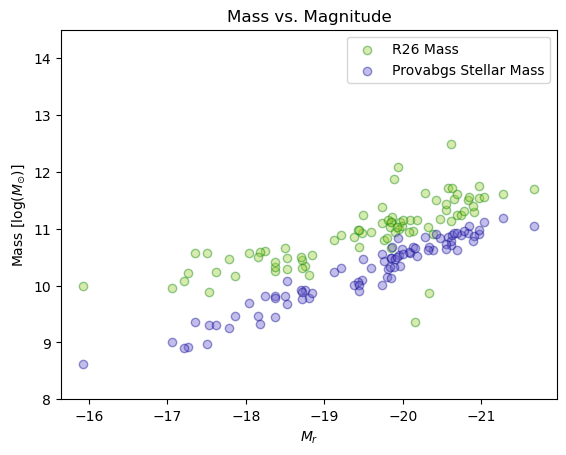

In [45]:
#total mass vs. provabgs stellar mass plotting each mass only once ONLY Y1 DATA
#plotting
x = sgas_1['RABS_MAG26']
y = sgas_1['M_R26']
z = sgas_1['M_STELLAR_PROVABGS']
#plot
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = 'R26 Mass')
plt.scatter(x, z, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(8, 14.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'provabgs_y1_stellar_total__mass_magplot.png', dpi=300)

#plots 84 galaxies

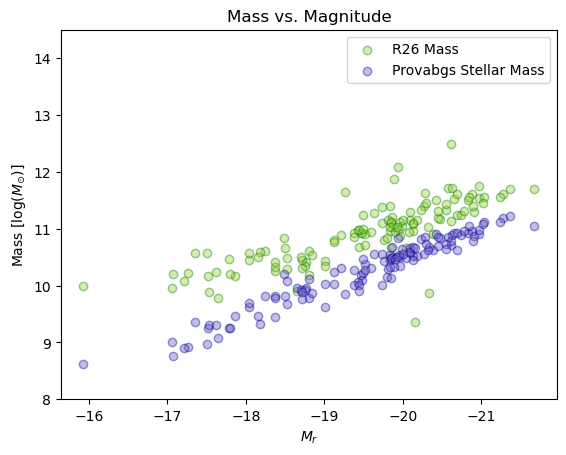

In [48]:
#total mass vs. provabgs stellar mass plotting each mass only once ONLY SV3 DATA
#plotting
x = sgas_sv3['RABS_MAG26']
y = sgas_sv3['M_R26']
z = sgas_sv3['M_STELLAR_PROVABGS']
#plot
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = 'R26 Mass')
plt.scatter(x, z, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(8, 14.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'provabgs_sv3_stellar_total__mass_magplot.png', dpi=300)

#plots 255 galaxies

In [42]:
#writing new data into table
tf_mastertable.write(data_dir + 'tf_mastertable_massmag_stellar.fits', format='fits', overwrite=True)